In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
filename = 'deu.txt'
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000,:]

In [6]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [7]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

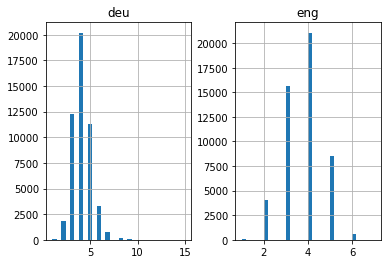

In [8]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [9]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [10]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6241


In [11]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10326


In [12]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [14]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [15]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [16]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [17]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [18]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4129
Epoch 00001: val_loss improved from inf to 2.94206, saving model to model.h1.24_jan_19
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
63/63 [==============================] - 220s 3s/step - loss: 3.4129 - val_loss: 2.9421
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7681
Epoch 00002: val_loss improved from 2.94206 to 2.72961, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
63/63 [==============================] - 223s 4s/step - loss: 2.7681 - val_loss: 2.7296
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.5742
Epoch 00003: val_loss improved from 2.72961 to 2.52730, saving mo

63/63 [==============================] - 229s 4s/step - loss: 0.6331 - val_loss: 1.3339
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.5861
Epoch 00025: val_loss improved from 1.33388 to 1.32625, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
63/63 [==============================] - 231s 4s/step - loss: 0.5861 - val_loss: 1.3262
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.5381
Epoch 00026: val_loss improved from 1.32625 to 1.31272, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
63/63 [==============================] - 234s 4s/step - loss: 0.5381 - val_loss: 1.3127
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.4972
Epoch 00027: val_loss improved from 1.31272 to 1.30003, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets
63/63 [==============================] - 229s 4s/ste

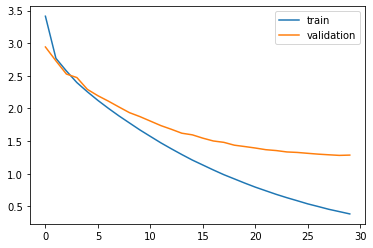

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [20]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [21]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [22]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [23]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [24]:
pred_df.sample(15)

,actual,predicted
4490,tom seemed sleepy,tom seemed tired
157,i didnt strangle tom,i didnt hated tom
4338,i know that voice,i know that guy
4139,let me have a look,let see
4950,he was shy at first,he was born poor dogs
4400,i love horses,i love spinach
629,i want toms money,i want the money
3955,wear warm clothes,turn on the robe
2136,tom was objective,tom was confused
519,he offered to help me,he told me to
